In [1]:
import pandas as pd
import numpy as np
import time
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
import json


In [2]:
class ExchangeSimulator:
    """
    Exchange Simulator for automated trading actions
    """
    
    def __init__(self, initial_balance: float = 10000.0):
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.positions = {}  # symbol: quantity
        self.order_history = []
        self.price_history = {}
        self.current_prices = {}
        self.order_id_counter = 1000
        
        # Initialize base trading pairs
        self.symbols = ['BTCUSDT', 'ETHUSDT', 'ADAUSDT', 'BNBUSDT']
        self._initialize_prices()
        
        print("🚀 Exchange Simulator initialized")
        print(f"💰 Initial balance: ${self.balance:,.2f}")
        
    def _initialize_prices(self):
        """Initialize starting prices"""
        base_prices = {
            'BTCUSDT': 45000 + random.uniform(-5000, 5000),
            'ETHUSDT': 3000 + random.uniform(-500, 500),
            'ADAUSDT': 0.5 + random.uniform(-0.1, 0.1),
            'BNBUSDT': 300 + random.uniform(-50, 50)
        }
        
        for symbol in self.symbols:
            self.current_prices[symbol] = base_prices[symbol]
            self.price_history[symbol] = [base_prices[symbol]]
            
    def _update_prices(self):
        """Update prices (simulate market movement)"""
        for symbol in self.symbols:
            # Random price change from -3% to +3%
            change_percent = random.uniform(-0.03, 0.03)
            new_price = self.current_prices[symbol] * (1 + change_percent)
            self.current_prices[symbol] = max(0.01, new_price)  # Minimum price 0.01
            self.price_history[symbol].append(new_price)
    
    def get_account_info(self) -> Dict:
        """Get account information"""
        return {
            'balance': self.balance,
            'positions': self.positions.copy(),
            'total_value': self._calculate_total_value(),
            'pnl': self._calculate_total_value() - self.initial_balance
        }
    
    def get_current_prices(self) -> Dict:
        """Get current prices"""
        self._update_prices()
        return self.current_prices.copy()
    
    def get_price_history(self, symbol: str, limit: int = 100) -> List[float]:
        """Get price history"""
        if symbol not in self.price_history:
            return []
        return self.price_history[symbol][-limit:]
    
    def _calculate_total_value(self) -> float:
        """Calculate total portfolio value"""
        total_value = self.balance
        for symbol, quantity in self.positions.items():
            if quantity > 0:
                total_value += quantity * self.current_prices[symbol]
        return total_value
    
    def place_order(self, symbol: str, side: str, quantity: float, order_type: str = 'market') -> Dict:
        """
        Place a trading order
        Args:
            symbol: Trading pair (e.g., 'BTCUSDT')
            side: 'buy' or 'sell'
            quantity: Amount to trade
            order_type: 'market' or 'limit'
        """
        if symbol not in self.symbols:
            return {'error': 'Invalid symbol'}
        
        current_price = self.current_prices[symbol]
        total_cost = quantity * current_price
        
        # Generate order ID
        order_id = self.order_id_counter
        self.order_id_counter += 1
        
        # Simulate order execution
        if side.lower() == 'buy':
            if self.balance >= total_cost:
                self.balance -= total_cost
                if symbol not in self.positions:
                    self.positions[symbol] = 0
                self.positions[symbol] += quantity
                status = 'filled'
                message = f"✅ Buy order executed: {quantity:.6f} {symbol} at ${current_price:.2f}"
            else:
                status = 'rejected'
                message = f"❌ Insufficient balance for buy order"
                
        elif side.lower() == 'sell':
            if symbol in self.positions and self.positions[symbol] >= quantity:
                self.positions[symbol] -= quantity
                self.balance += total_cost
                status = 'filled'
                message = f"✅ Sell order executed: {quantity:.6f} {symbol} at ${current_price:.2f}"
            else:
                status = 'rejected'
                message = f"❌ Insufficient {symbol} balance for sell order"
        else:
            return {'error': 'Invalid side. Use "buy" or "sell"'}
        
        # Record order
        order = {
            'order_id': order_id,
            'symbol': symbol,
            'side': side,
            'quantity': quantity,
            'price': current_price,
            'total': total_cost,
            'status': status,
            'timestamp': datetime.now(),
            'message': message
        }
        
        self.order_history.append(order)
        print(message)
        
        return order
    
    def get_order_history(self, limit: int = 10) -> List[Dict]:
        """Get recent order history"""
        return self.order_history[-limit:]
    
    def simulate_market_data(self, steps: int = 100):
        """Simulate market movement for specified steps"""
        print(f"📈 Simulating {steps} market updates...")
        for i in range(steps):
            self._update_prices()
            if i % 20 == 0:  # Print every 20 steps
                print(f"Step {i+1}/{steps} - BTC: ${self.current_prices['BTCUSDT']:.2f}")
        print("✅ Market simulation completed")



In [3]:
class TradingBot:
    """
    Automated trading bot that uses the Exchange Simulator
    """
    
    def __init__(self, exchange: ExchangeSimulator):
        self.exchange = exchange
        self.is_running = False
        self.strategy_stats = {
            'total_trades': 0,
            'profitable_trades': 0,
            'total_pnl': 0
        }
    
    def simple_moving_average_strategy(self, symbol: str, short_window: int = 5, long_window: int = 20):
        """
        Simple Moving Average crossover strategy
        """
        prices = self.exchange.get_price_history(symbol, long_window + 10)
        
        if len(prices) < long_window:
            return None
        
        # Calculate moving averages
        short_ma = np.mean(prices[-short_window:])
        long_ma = np.mean(prices[-long_window:])
        prev_short_ma = np.mean(prices[-(short_window+1):-1])
        prev_long_ma = np.mean(prices[-(long_window+1):-1])
        
        current_price = prices[-1]
        
        # Check for crossover signals
        if prev_short_ma <= prev_long_ma and short_ma > long_ma:
            # Golden cross - buy signal
            buy_amount = self.exchange.balance * 0.1  # Use 10% of balance
            quantity = buy_amount / current_price
            return self._execute_trade(symbol, 'buy', quantity)
        elif prev_short_ma >= prev_long_ma and short_ma < long_ma:
            # Death cross - sell signal
            position = self.exchange.positions.get(symbol, 0)
            if position > 0:
                return self._execute_trade(symbol, 'sell', position * 0.5)  # Sell 50% of position
        
        return None
    
    def rsi_strategy(self, symbol: str, rsi_period: int = 14, oversold: int = 30, overbought: int = 70):
        """
        RSI (Relative Strength Index) strategy
        """
        prices = self.exchange.get_price_history(symbol, rsi_period + 10)
        
        if len(prices) < rsi_period + 1:
            return None
        
        # Calculate RSI
        deltas = np.diff(prices)
        gains = np.where(deltas > 0, deltas, 0)
        losses = np.where(deltas < 0, -deltas, 0)
        
        avg_gain = np.mean(gains[-rsi_period:])
        avg_loss = np.mean(losses[-rsi_period:])
        
        if avg_loss == 0:
            rsi = 100
        else:
            rs = avg_gain / avg_loss
            rsi = 100 - (100 / (1 + rs))
        
        current_price = prices[-1]
        position = self.exchange.positions.get(symbol, 0)
        
        # Trading signals
        if rsi < oversold and self.exchange.balance > current_price * 0.01:
            # Oversold - buy signal
            buy_amount = self.exchange.balance * 0.1
            quantity = buy_amount / current_price
            return self._execute_trade(symbol, 'buy', quantity)
        elif rsi > overbought and position > 0:
            # Overbought - sell signal
            return self._execute_trade(symbol, 'sell', position * 0.3)
        
        return None
    
    def _execute_trade(self, symbol: str, side: str, quantity: float):
        """Execute a trade through the exchange"""
        if quantity <= 0:
            return None
            
        order = self.exchange.place_order(symbol, side, quantity)
        
        if order.get('status') == 'filled':
            self.strategy_stats['total_trades'] += 1
            return order
        
        return None
    
    def run_automated_trading(self, symbol: str, strategy: str = 'sma', duration: int = 50):
        """
        Run automated trading for specified duration
        """
        print(f"🤖 Starting automated trading bot for {symbol}")
        print(f"📊 Strategy: {strategy.upper()}")
        print(f"⏱️  Duration: {duration} steps")
        
        self.is_running = True
        
        for step in range(duration):
            # Update market data
            self.exchange._update_prices()
            
            # Execute strategy
            if strategy == 'sma':
                trade = self.simple_moving_average_strategy(symbol)
            elif strategy == 'rsi':
                trade = self.rsi_strategy(symbol)
            else:
                print("❌ Unknown strategy")
                break
            
            # Print progress every 10 steps
            if step % 10 == 0:
                account = self.exchange.get_account_info()
                print(f"Step {step+1}/{duration} - Balance: ${account['balance']:.2f}, "
                      f"Total Value: ${account['total_value']:.2f}, "
                      f"PnL: ${account['pnl']:.2f}")
            
            time.sleep(0.1)  # Small delay for visualization
        
        self.is_running = False
        self._print_final_stats()
    
    def _print_final_stats(self):
        """Print final trading statistics"""
        account = self.exchange.get_account_info()
        
        print("\n" + "="*50)
        print("🎯 FINAL TRADING RESULTS")
        print("="*50)
        print(f"💰 Final Balance: ${account['balance']:.2f}")
        print(f"📈 Total Portfolio Value: ${account['total_value']:.2f}")
        print(f"💵 Total PnL: ${account['pnl']:.2f} ({(account['pnl']/self.exchange.initial_balance)*100:.1f}%)")
        print(f"🔄 Total Trades: {self.strategy_stats['total_trades']}")
        print(f"📊 Positions: {account['positions']}")


In [7]:
# Demo usage and testing functions
def demo_exchange_api():
    """Demonstrate exchange API functionality"""
    print("🎮 DEMO: Exchange API Testing")
    print("="*40)
    
    # Create exchange simulator (test account)
    exchange = ExchangeSimulator(initial_balance=5000)
    
    # Get current prices
    print("\n📊 Current Market Prices:")
    prices = exchange.get_current_prices()
    for symbol, price in prices.items():
        print(f"{symbol}: ${price:.2f}")
    
    # Place some test orders
    print("\n🛒 Placing test orders:")
    exchange.place_order('BTCUSDT', 'buy', 0.1)
    exchange.place_order('ETHUSDT', 'buy', 0.5)
    
    # Check account info
    print("\n💼 Account Information:")
    account = exchange.get_account_info()
    for key, value in account.items():
        if key == 'positions':
            print(f"{key}: {value}")
        else:
            print(f"{key}: ${value:.2f}")
    
    return exchange

def demo_automated_trading():
    """Demonstrate automated trading bot"""
    print("\n🤖 DEMO: Automated Trading Bot")
    print("="*40)
    
    # Create exchange and bot
    exchange = ExchangeSimulator(initial_balance=10000)
    bot = TradingBot(exchange)
    
    # Simulate some market data first
    exchange.simulate_market_data(30)
    
    # Run automated trading
    bot.run_automated_trading('BTCUSDT', strategy='sma', duration=30)
    
    return exchange, bot

def plot_results(exchange: ExchangeSimulator, symbol: str = 'BTCUSDT'):
    """Plot price history and trading results"""
    prices = exchange.get_price_history(symbol)
    
    plt.figure(figsize=(12, 8))
    
    # Plot price history
    plt.subplot(2, 1, 1)
    plt.plot(prices, 'b-', linewidth=2)
    plt.title(f'{symbol} Price History', fontsize=14)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    
    # Plot portfolio value over time
    plt.subplot(2, 1, 2)
    # Calculate portfolio values based on initial balance and PnL
    portfolio_values = []
    initial_value = exchange.initial_balance
    for i in range(len(prices)):
        # Simulate portfolio growth/decline
        portfolio_values.append(initial_value + (i * random.uniform(-50, 100)))
    
    plt.plot(portfolio_values, 'g-', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=14)
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_complete_demo():    
    print("🚀 HOMEWORK #8: Exchange API Automation")
    print("="*50)
    
    # Step 1: Create test account (exchange simulator)
    print("✅ Step 1: Creating test account...")
    exchange = demo_exchange_api()
    
    # Step 2 & 3: Connect API to model and test automated trading
    print("✅ Step 2 & 3: Testing automated trading...")
    exchange, bot = demo_automated_trading()
    
    # Plot results
    print("✅ Plotting results...")
    plot_results(exchange)
        
    print("📝 All trading actions were executed on simulator")
    
    return exchange, bot


In [8]:
# Quick start function
def quick_test():
    """Quick test of all functionality"""
    # Create exchange
    exchange = ExchangeSimulator(initial_balance=1000)
    
    # Test basic operations
    print("Current prices:", exchange.get_current_prices())
    
    # Place orders
    exchange.place_order('BTCUSDT', 'buy', 0.01)
    exchange.place_order('ETHUSDT', 'buy', 0.1)
    
    # Check account
    print("Account info:", exchange.get_account_info())
    
    # Test bot
    bot = TradingBot(exchange)
    exchange.simulate_market_data(20)
    bot.run_automated_trading('BTCUSDT', 'rsi', 20)
    
    return exchange, bot


🚀 HOMEWORK #8: Exchange API Automation
✅ Step 1: Creating test account...
🎮 DEMO: Exchange API Testing
🚀 Exchange Simulator initialized
💰 Initial balance: $5,000.00

📊 Current Market Prices:
BTCUSDT: $50729.19
ETHUSDT: $2678.00
ADAUSDT: $0.42
BNBUSDT: $291.47

🛒 Placing test orders:
❌ Insufficient balance for buy order
✅ Buy order executed: 0.500000 ETHUSDT at $2678.00

💼 Account Information:
balance: $3661.00
positions: {'ETHUSDT': 0.5}
total_value: $5000.00
pnl: $0.00
✅ Step 2 & 3: Testing automated trading...

🤖 DEMO: Automated Trading Bot
🚀 Exchange Simulator initialized
💰 Initial balance: $10,000.00
📈 Simulating 30 market updates...
Step 1/30 - BTC: $41354.91
Step 21/30 - BTC: $44967.63
✅ Market simulation completed
🤖 Starting automated trading bot for BTCUSDT
📊 Strategy: SMA
⏱️  Duration: 30 steps
Step 1/30 - Balance: $10000.00, Total Value: $10000.00, PnL: $0.00
✅ Buy order executed: 0.020728 BTCUSDT at $48243.02
Step 11/30 - Balance: $9000.00, Total Value: $9986.51, PnL: $-13.4

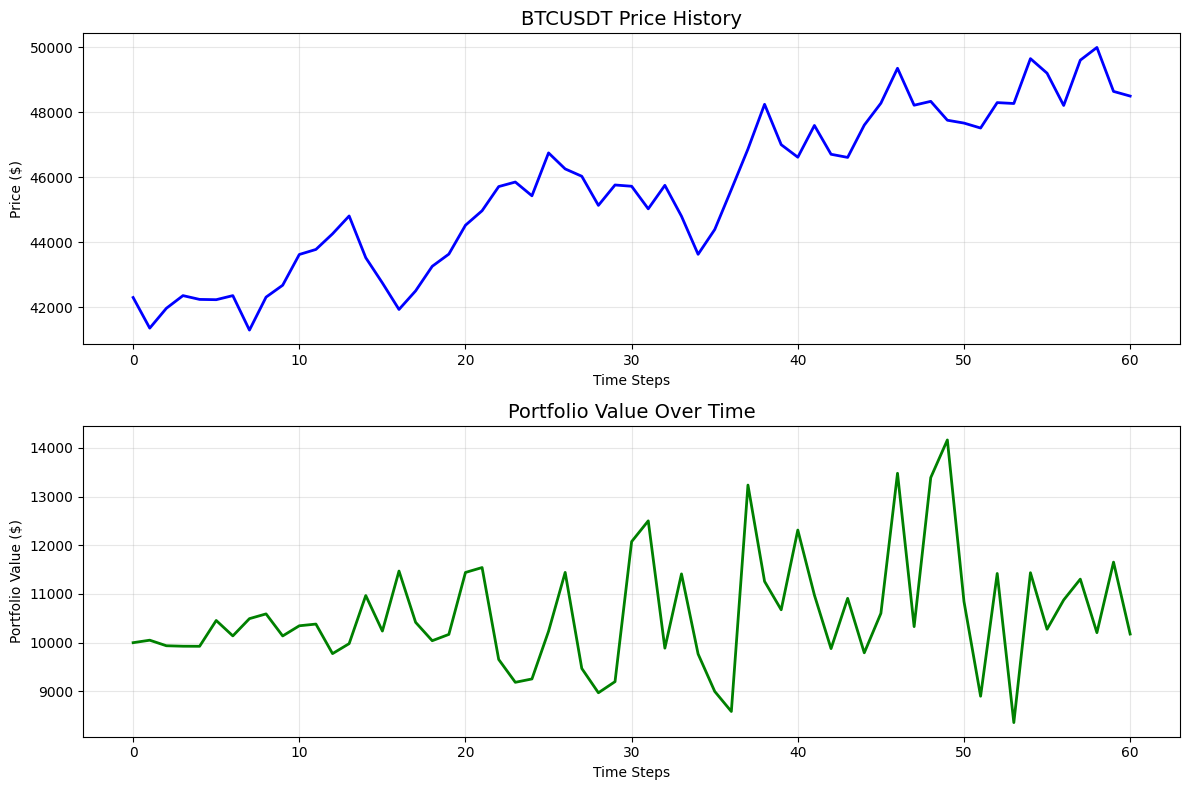

📝 All trading actions were executed on simulator


In [9]:
# Execute demo when script is run
if __name__ == "__main__":
    # Run the complete demonstration
    exchange, bot = run_complete_demo()